In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetV2S
import matplotlib.pyplot as plt

In [2]:
# List available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
   print(f"GPUs detected: {len(gpus)}")
   for gpu in gpus:
      print(f"GPU Name: {gpu}")
else:
   print("No GPU detected. Running on CPU.")

GPUs detected: 1
GPU Name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
image_size = 384
batch_size = 32
channels=3
epochs=100

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "../../datasets/data2.5k/",
   shuffle = True,
   image_size = (image_size, image_size),
   batch_size = batch_size
)

Found 2500 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
print(class_names)


['CBB', 'CBSD', 'CGM', 'CH', 'CMD']


In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 384, 384, 3)
[2 4 3 4 1 1 3 4 3 2 4 2 3 3 1 4 0 0 0 3 0 4 2 4 2 1 0 1 3 4 3 0]


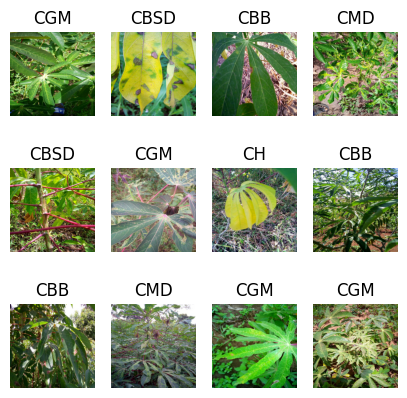

In [7]:
plt.figure(figsize=(5, 5))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8
len(dataset) * train_size

63.2

In [9]:
train_ds = dataset.take(535)
len(train_ds)

79

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(f'train: {len(train_ds)}')
print(f'val: {len(val_ds)}')
print(f'test: {len(test_ds)}')

train: 63
val: 7
test: 9


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2S  
from tensorflow.keras.optimizers import Adam

input_shape = (image_size, image_size, channels)  # Exclude batch_size
n_classes = 5

# Load EfficientNetV2 as the base model
model = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=5,
    classifier_activation='softmax',
    include_preprocessing=True
)

model.build(input_shape=input_shape)


In [17]:
model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 384, 384, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 192, 192, 24  648         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [18]:
model.compile(
   optimizer='adam',
   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
   metrics=['accuracy']
)

In [19]:
history = model.fit(
   train_ds,
   batch_size=batch_size,
   validation_data=val_ds,
   verbose=1,
   epochs=epochs,
)

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'efficientnetv2-s/block4b_bn/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\nicho\AppData\Local\Temp\ipykernel_24996\4054536119.py", line 1, in <module>
      history = model.fit(
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\nicho\anaconda3\envs\cassava\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'efficientnetv2-s/block4b_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,24,24,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node efficientnetv2-s/block4b_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_40412]

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
type(history.history['loss'])

In [ ]:
len(history.history['loss'])

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
   first_image = images_batch[0].numpy().astype('uint8')
   first_label = labels_batch[0].numpy()
   
   print("first image to predict")
   plt.imshow(first_image)
   print("actual label:",class_names[first_label])
   
   batch_prediction = model.predict(images_batch)
   print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, images):
   img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
   img_array = tf.expand_dims(img_array, 0)

   predictions = model.predict(img_array)

   predicted_class = class_names[np.argmax(predictions[0])]
   confidence = round(100 * (np.max(predictions[0])), 2)
   return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("saved_model/cassava.h5")